In [1]:
from qutip import *
import numpy as np

In [2]:
# Defining the system Hamiltonian
eps = 0.0    # Energy of the 2-level system.
Del = 0.2    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()
tlist=np.linspace(0,10,1000)

## Spectral density fitting

In [3]:
w = np.linspace(0, 20, 20000)
def ohmic_spectral_density(w, alpha, wc):
    """ The Ohmic bath spectral density as a function of w
        (and the bath parameters).
    """
    return w * alpha * np.e**(-w / wc)

In [4]:
alpha=0.05
T=1
wc=1

In [5]:
J=ohmic_spectral_density(w,alpha,wc)

In [6]:
obp=heom.FitSpectral(alpha,T,wc,sigmax())

In [7]:
obp.get_fit(J,w,final_rmse=1e-4)

Parameters [k=1]: lam=[0.09458064]; gamma=[1.779439]; w0=[0.100005], Obtain a normalized RMSE of 0.00016082569123328715
Parameters [k=2]: lam=[0.03401297 0.05021536]; gamma=[1.24940346 1.43483174]; w0=[0.100005   1.80514724], Obtain a normalized RMSE of 7.935920006974142e-05


In [8]:
options = {'nsteps':15000, 'store_states':True, 'rtol':1e-12, 'atol':1e-12, 'method':"bdf"}
HEOM_spectral_fit = heom.HEOMSolver(Hsys, obp.Bath_spec, max_depth=4, options=options,)
result_spectral=HEOM_spectral_fit.run(rho0,tlist)

10.0%. Run time:   1.28s. Est. time left: 00:00:00:11
20.0%. Run time:   2.51s. Est. time left: 00:00:00:10
30.0%. Run time:   3.76s. Est. time left: 00:00:00:08
40.0%. Run time:   4.90s. Est. time left: 00:00:00:07
50.1%. Run time:   5.96s. Est. time left: 00:00:00:05
60.1%. Run time:   7.05s. Est. time left: 00:00:00:04
70.1%. Run time:   8.19s. Est. time left: 00:00:00:03
80.1%. Run time:   9.34s. Est. time left: 00:00:00:02
90.1%. Run time:  10.47s. Est. time left: 00:00:00:01
100.0%. Run time:  11.62s. Est. time left: 00:00:00:00
Total run time:  11.62s


## Correlation Function Fitting

In [9]:
from mpmath import mp
alpha=0.05
T=1
wc=1

In [10]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """ The Ohmic bath correlation function as a function of t
        (and the bath parameters).
    """
    corr = (
        (1 / np.pi) * alpha * wc**(1 - s) * beta**(-(s + 1)) * mp.gamma(s + 1)
    )
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array([
        complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
        for u1, u2 in zip(z1_u, z2_u)
    ], dtype=np.complex128)

In [11]:
C=ohmic_correlation(tlist,alpha,wc,1/T)

In [12]:
obp2=heom.FitCorr(T,sigmax())

In [13]:
obp2.fit_correlation(tlist,C,wc,final_rmse=5e-4)

Parameters [k=1]: lam=[0.03997172]; gamma=[-0.93011559]; w0=[4.1303769e-13], Obtain a normalized RMSE of 0.0006445667418475704
Parameters [k=1]: lam=[-0.18222192]; gamma=[-1.75906529]; w0=[0.25732491], Obtain a normalized RMSE of 0.0007289292847508476
Parameters [k=2]: lam=[0.01946082 0.0201027 ]; gamma=[-1.00832485 -0.54380531]; w0=[1.02317024e+00 3.15771480e-05], Obtain a normalized RMSE of 0.0003235270925995683
Parameters [k=2]: lam=[-0.18222191 -0.01388122]; gamma=[-1.25080414 -1.43414172]; w0=[0.09353412 1.80587667], Obtain a normalized RMSE of 0.0003542547990932083


In [14]:
obp2.fit_correlation(tlist,C,wc,Ni=3,Nr=4)

Parameters [k=4]: lam=[ 0.72888766  0.02681124  0.00351171 -0.72274992]; gamma=[-4.4769911  -0.99053624 -0.24886006 -4.55094293]; w0=[5.51836478e-04 2.16109850e-05 1.25246283e-05 6.12959581e-01], Obtain a normalized RMSE of 8.963976919681359e-06
Parameters [k=3]: lam=[-0.07427189 -0.18222137 -0.01388121]; gamma=[-1.71964502 -1.25080469 -1.43414185]; w0=[1.13855481e-33 9.35345323e-02 1.80587751e+00], Obtain a normalized RMSE of 0.0003542547992099876


In [15]:
HEOM_corr_fit = heom.HEOMSolver(Hsys, obp2.Bath_corr, max_depth=4, options=options,)
result_corr=HEOM_corr_fit.run(rho0,tlist)

10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.22s. Est. time left: 00:00:00:00
30.0%. Run time:   0.27s. Est. time left: 00:00:00:00
40.0%. Run time:   0.31s. Est. time left: 00:00:00:00
50.1%. Run time:   0.36s. Est. time left: 00:00:00:00
60.1%. Run time:   0.41s. Est. time left: 00:00:00:00
70.1%. Run time:   0.45s. Est. time left: 00:00:00:00
80.1%. Run time:   0.50s. Est. time left: 00:00:00:00
90.1%. Run time:   0.54s. Est. time left: 00:00:00:00
100.0%. Run time:   0.58s. Est. time left: 00:00:00:00
Total run time:   0.59s


# Comparison between fits

In [16]:
def projection(result,i,j):
    return [result.states[k][i,j] for k in range(len(result.states))]

In [17]:
import matplotlib.pyplot as plt

/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


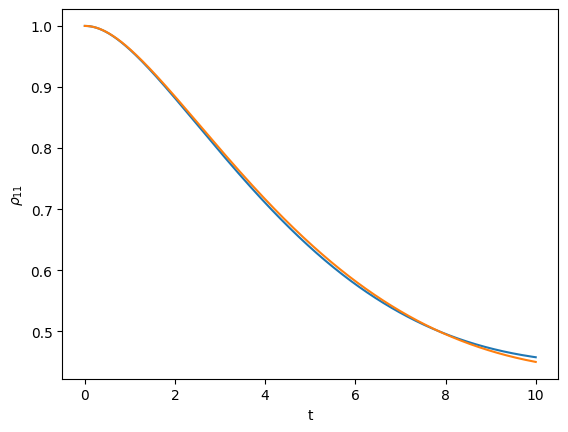

In [18]:
plt.plot(tlist,projection(result_corr,0,0))
plt.plot(tlist,projection(result_spectral,0,0))
plt.xlabel('t')
plt.ylabel(r'$\rho_{11}$')
plt.show()

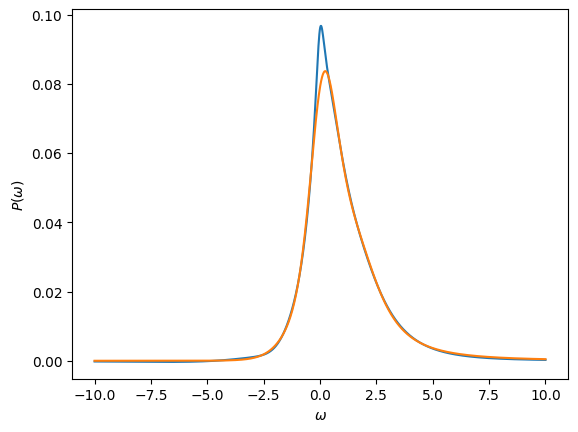

In [19]:
w=np.linspace(-10,10,1000)
plt.plot(w,obp2.corr_spectrum_approx(w))
plt.plot(w,obp.spec_spectrum_approx(w))
plt.ylabel(r'$P( \omega )$')
plt.xlabel(r'$\omega$')
plt.show()